# Training the Neural Network with PyTorch Lightning
## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# PyTorch
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer

# From src
from src.prepare_data import TSDataset
from src.inference import format_predictions, calculate_metrics
from src.models import GatedRecurrentUnit
from src.model_training import TrainingLoop

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device} is available.")

cpu is available.


In [3]:
# Seed
seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [4]:
# Config
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 32
EPOCHS = 20

## Data

In [5]:
# Load data
load_data = pd.read_csv('../data/electricity_load_data.csv', index_col=['datetime'], parse_dates=True)

In [6]:
# Generate target and input variables
dataset = TSDataset(dataframe=load_data, target_variable='load')
X, y = dataset.to_supervised(n_lags=23, horizon=1)

In [7]:
print(f'Target Variable Shape: {y.shape}\nInput Variables Shape: {X.shape}')

Target Variable Shape: (29520, 1)
Input Variables Shape: (29520, 24)


In [8]:
test_ratio = 0.2
val_ratio = test_ratio / (1-test_ratio)

In [9]:
# Split set once for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

# Split once more for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)

In [10]:
# Reshape to 2D
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)


print(f'Train Data Shape:\t{X_train.shape}\t{y_train.shape}')
print(f'Validation Data Shape:\t{X_val.shape}\t{y_val.shape}')
print(f'Test Data Shape:\t{X_test.shape}\t{y_test.shape}')

Train Data Shape:	(17712, 24)	(17712, 1)
Validation Data Shape:	(5904, 24)	(5904, 1)
Test Data Shape:	(5904, 24)	(5904, 1)


In [11]:
# Scale data
scaler = StandardScaler()

# Scale X
X_train_scl = scaler.fit_transform(X_train)
X_val_scl = scaler.transform(X_val)
X_test_scl = scaler.transform(X_test)

# Scale y
y_train_scl = scaler.fit_transform(y_train)
y_val_scl = scaler.transform(y_val)
y_test_scl = scaler.transform(y_test)

In [12]:
# Create Tensors out of the data
train_features = torch.Tensor(X_train_scl)
train_targets = torch.Tensor(y_train_scl)
val_features = torch.Tensor(X_val_scl)
val_targets = torch.Tensor(y_val_scl)
test_features = torch.Tensor(X_test_scl)
test_targets = torch.Tensor(y_test_scl)

# Torch Tensor Datasets
train_ds = TensorDataset(train_features, train_targets)
val_ds = TensorDataset(val_features, val_targets)
test_ds = TensorDataset(test_features, test_targets)

## Model Training

In [13]:
# Hyperparameters
input_size = len(X_train.columns) 
output_size = y_train.shape[1]
hidden_size = 64
num_layers = 1
dropout_prob = 0
learning_rate = 1e-2

optimizer = 'SGD'
loss_fn = nn.MSELoss()

In [14]:
# Build model
model = GatedRecurrentUnit(
    hidden_size = hidden_size,
    num_rnn_layers = num_layers,
    input_size = input_size,
    output_size = output_size,
    dropout = dropout_prob,
    device = device
    )


print(model)

GatedRecurrentUnit(
  (gru): GRU(24, 64, batch_first=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [15]:
train_loop = TrainingLoop(
            model=model, 
            datasets=(train_ds, val_ds, test_ds),
            learning_rate=learning_rate,
            batch_size=BATCH_SIZE,
            optimizer=optimizer,
            accelerator=device,
            train_shuffle=False
        )

In [16]:
trainer = pl.Trainer(
    accelerator=device,
    devices=1,
    min_epochs=1,
    max_epochs=EPOCHS,
    gradient_clip_val=0,
    check_val_every_n_epoch=1,
    val_check_interval=1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\nva\Documents\Teaching\external\lighthouse-course\venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [17]:
trainer.fit(train_loop)


  | Name  | Type               | Params
---------------------------------------------
0 | model | GatedRecurrentUnit | 17.3 K
---------------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\nva\Documents\Teaching\external\lighthouse-course\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\nva\Documents\Teaching\external\lighthouse-course\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [18]:
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at C:\Users\nva\Documents\Teaching\external\lighthouse-course\notebooks\lightning_logs\version_32\checkpoints\epoch=19-step=11060.ckpt
Loaded model weights from checkpoint at C:\Users\nva\Documents\Teaching\external\lighthouse-course\notebooks\lightning_logs\version_32\checkpoints\epoch=19-step=11060.ckpt
C:\Users\nva\Documents\Teaching\external\lighthouse-course\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{}]

In [19]:
predictions, labels = train_loop.predictions, train_loop.values

In [20]:
df_result = format_predictions(predictions, labels, X_test, scaler)

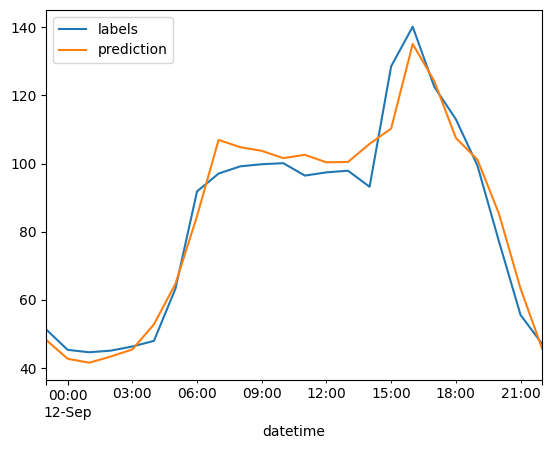

In [21]:
df_result.iloc[:24].plot()
plt.show()

In [22]:
# Calculate error/performance metrics
metrics = calculate_metrics(df_result['labels'], df_result['prediction'])

Mean Absolute Error: 5.3071523
Mean Absolute % Error: 6.213662028312683
Symmetric Mean Absolute % Error: 6.213662028312683
Root Mean Squared Error: 6.980669579074545
R^2 Score: 0.9500598096875524
